# "Fast dropout training", Wang, Manning, 2013

# Abstract

"Preventing feature co-adaptation by encouraging independent contributions from different features often improves classification and regression performance. Dropout training ("Improving Neural Networks by Preventing Co-adaptation of Feature Detectors") does this by randomly dropping out (zeroing) hidden units and input features during training of neural networks. However, repeatedly sampling a random subset of input features makes training much slower. Based on an examination of the implied objective function of dropout training, we show how to do fast dropout training by sampling from or integrating a Gaussian approximation, instead of doing Monte Carlo optimization of this objective. This approximation, justified by the central limit theorem and empirical evidence, gives an order of magnitude speedup and more stability. We show how to do fast dropout training for classification, regression, and multilayer neural networks. Beyond dropout, our technique is extended to integrate out other types of noise and small image transformation."

# 1. Introduction

"Recent work ("Improving neural networks by preventing co-adaptation of feature detectors") has shown that preventing feature co-adaptation by dropout training is a promising method for regularization. Applied to neural network training, the idea is to dropout (zero) randomly sampled hidden units and input features during each iteration of optimization. Dropout played an important role in the systems that won recent learning competitions such as ImageNet classification (Krizhevsky et al, 2012) and the Merck molecular activity challenge at www.kaggle.com, and improves performance on various tasks. Dropout can be consider another approach to regularization in addition to the widely used parameter shrinkage methods and model averaging. This process lowers the trust in a feature that is only helpful when other specific features are present, since any particular feature may be dropped out and cannot be depended on. Alternatively, the procedure can be seen as averaging over many neural networks with shared weights.

"Other observations of harmful co-adaptation and ways to address them exist in the literature. Naive Bayes, by completely ignoring co-adaptation, performs better than discriminative methods when there is little data ('On discriminative vs generative classifiers: a comparison of logistic regression and naive bayes', 2002), and continues to perform better on certain relatively large datasets ('Baselines and bigrams: simple, good sentiment and topic classification', 2012). In 'Reducing weight undertraining in structured discriminative learning', Sutton et al 2006, it is observed that training involves trade-offs among weights, where the presence of highly indicative features can cause other useful but weaker features to undertrain. They propose feature bagging: training different models on subsets of features that are combined, an idea further pursued under the name logarithmic opinion pools by 'Logarithmic opinion pools for conditional random fields', Smith et al 2005. Improved performance on Named Entity Recognition and Part-of-Speech Tagging was demonstrated.

"While the effectiveness of these methods in preventing feature co-adaptation has been demonstrated, actually sampling, or training multiple models, make training slower. Moreover, with a dropout rate of $p$, the proportion of the data still not seen after $n$ passes is $p^n$ (eg 5 passes of the data are required to see 95% of it at $p = 0.5$). If the data is not highly redundant, and if we make the relevant data only partially observable at ranom, then the task becomes even harder, and training efficiency may reduce further.

"In this paper, we look at how to achieve the benefit of dropout training without actually sampling, thereby using all the data efficiently. The approach uses a Gaussian approximation that is justified by the central limit theorem and empirical evidence. We show the validity of this approximation and how it can provide an order of magnitude speed-up at training time, while also giving more stability. Fast dropout fits into the general framework of integrating out noise added by the training data ('Noise injection into inputs in back-propagation learning', 1992; 'Training with noise is equivalent to Tikhonov regularization', Bishop, 1995). See 'Learning with marginalized corrupted features', van der Maaten, 2013, for an alternative approach to integrating out noise and a survey of related work from that angle. Their approach is exact for loss functions decomposable by the moment generating function of the independent noise such as the exponential loss and squared error loss. Our approach does not require independence: it can integrate out small transformations that an image classifier should be invariant to. We begin with logistic regression for simplicity, then extend the idea to other loss functions, other noise, and neural networks. Code is provided at the author's website."

# 2. Fast approximations to dropout$\def\Bernoulli{\text{Bernoulli}}
\def\diag{\text{diag}}$

## 2.1 The implied objective function

"We illustrate the idea with logistic regression (LR) given training vector $x$, and label $y \in \{0, 1\}$. To train LR with dropout on data with dimension $m$, first sample $z_i \sim \Bernoulli(p_i)$ for $i=1\dots m$. Here $p_i$ is the probability of not dropping out input $x_i$. After sampling $\mathbf{z} = \{z_i\}_{i=1\dots m}$ we can compute the stochastic gradient descent (sgd) update as follows:

$$
\Delta \mathbf{w} = (\mathbf{y} - \sigma(\mathbf{w}^T D_\mathbf{z} \mathbf{x}))D_\mathbf{z} \mathbf{x}
$$

... where $D_\mathbf{z} = \diag(\mathbf{z}) \in \mathbb{R}^{m \times n}$, and $\sigma(x) = 1 / (1 + e^{-x})$ is the logistic function.

"This update rule, applied over the training data for multiple passes, can be seen as a Monte Carlo approximation to the following gradient:

$$
\Delta \bar{\mathbf{w}} = \mathbb{E}_{\mathbf{z};z_i \sim \Bernoulli(p_i)} \left[
    (\mathbf{y} - \sigma(\mathbf{w}^T D_\mathbf{z} \mathbf{x})) D_\mathbf{z} \mathbf{x}
\right]
$$

The objective function with the above gradient is the expected conditional log-likelihood of the label given the data with dropped out dimensions indicated by $\mathbf{z}$, for $\mathbf{y} \sim \Bernoulli(\sigma(\mathbf{w}^T D_\mathbf{z} \mathbf{x})))$. This is the implied objective function for dropout training:

$$
L(\mathbf{w}) = \mathbb{E}_\mathbf{z}\left[
    \log(p(\mathbf{y} \mid D_\mathbf{z} \mathbf{x}; \mathbf{w})
\right] \\
= \mathbb{E}_\mathbf{z} \left[
    \mathbf{y} \log(\sigma(\mathbf{w}^T D_\mathbf{z} \mathbf{x})) +
    (1 - \mathbf{y}) \log(1 - \sigma(\mathbf{w}^T D_\mathbf{z} \mathbf{x}))
\right]
$$


"Since we are just taking an expectation, we still have a convex optimization problem provided taht the negative log-likelihood is convex.

"Evaluating the expectation in (1) naively by summing over all possible $\mathbf{z}$ has complexity $O(2^mm)$. Rather than directly computing the expectation with respect to $\mathbf{z}$, we propose a variable transformation that allows us to approximately compute the expectation with respect to a simple random variable $Y \in \mathbb{R}$, instead of $\mathbf{z} \in \{0,1\}^m$. In the next subsection, we describe an efficient $O(m)$ approximation that is accurate for machine learning applications where $w_i x_i$ usually come from a unimodal or bounded distribution.

## 2.2 The Gaussian approximation

"We make the observation that evaluating the objective function $L(w)$ involves taking the expectation with respect to the variable $Y(\mathbf{z}) = \mathbf{w}^TD_\mathbf{z} \mathbf{x} = \sum_i^m w_i x_i z_i$, a weighted sum of Bernoulli random variables. For most machine learning problems, $\{ w_i \}$ typically forms a unimodal distribution centred at $0$, $\{x_i\}$ is either unimodal or in a fixed interval. In this case, $Y$ can be well approximated by a normal distribution even for relatively low dimensional data with $m=10$. More technically, the Lyapunov condition is generally satisfied for a weighted sum of Bernoulli random variables of the form $Y$ that are weighted by real data ('Elements of Large-Sample Theory', Lehmann 1998). Then, Lyapunov's central limit theorem states that $Y(z)$ tends to a normal distribution as $m \rightarrow \infty$ (see figure 1). We empirically verify that the approximation is good for typical datasets of moderate dimensions, except when a couple of dimensions dominate all others (see figure 3). Finally, let $S$ be the approximating Gaussian ($Y \xrightarrow{d} S)$

$$
\def\Var{\text{Var}}
S = \mathbb{E}_\mathbf{z} [ Y(\mathbf{z}) ]
+ \sqrt{\Var[Y(z)]} \epsilon
 = \mu_S + \sigma_S \epsilon
 \tag{3}
$$

where:

- $\epsilon \sim \mathcal{N}(0,1)$,
- $\def\z{\mathbf{z}}\mathbb{E}[Y(\z)] = \sum_{i=1}^m p_i w_i x_i$, and
- $\Var[Y(\z)] = \sum_{i=1}^m p_i(1-p_i)w_ix_i)^2$

"In the following subsections, based on the Gaussian assumptions above, we present several approximations at different tradeoff points between speed and accuracy. In the end, we present experimental results showing that there is little to no performance loss when using the faster, less accurate approximations."

## 2.3 Gradient computation by sampling from the Gaussian

"Given good convergence, we note that drawing samples of the approximating Gaussian $S$ of $Y(\z)$, a constant time operation, is much cheaper than drawing samples of $Y(\z)$ directly, which takes $O(m)$. This effect is very significant for high dimensional datasets. So without doing much, we can already approximate the objective function (2) $m$ times faster by sampling from $S$ instead of $Y(\z)$. Empiricallly, this approximation is within the variance of the direct MC approximation of (2) by taking 200 samples of $\z$.

"Approximating the gradient introduces a complication when using samples from the Gaussian. The gradient (1) involves not only $Y(\z) \rightarrow{d} S$, but also $\def\x{\mathbf{x}}D_\z \x$ directly:

$$
\nabla L(w) = \mathbb{E}_\z\left[
    (y - \sigma(Y(\z)))D_\z \x
\right]
$$

"Let $f(Y(\z)) = y - \sigma(Y(\z))$ and let $g(\z) = D_\z \x$. Naively approximating $\mathbf{E}[f(Y(\z))g(\z)]$ by either $\mathbb{E}_S[f(S)]\mathbb{E}_\z[g(\z)]$, or worse, by $\def\Exp{\mathbb{E}}f(\Exp_S[S])\Exp_\z[g(\z)]$ works poorly in terms of both approximation error and final performance. Note that $g(\z)$ is a linear function and therefore $\Exp_\z[g(\z)] = g(\Exp_\z[\z]) = \diag(p)\x$. A good way to approximate (4) is by analytically taking the expectation with respect to $z_i$ and then using a linear approximation to the conditional expectation. More precisely, consider dimension $i$ of the gradient:

$$
\frac{\partial L(w)}
  {\partial w_i}
  = \Exp_\z[f(Y(\z))x_i z_i] \\
  = \sum_{z_i \in \{0, 1\}} p(z_i) z_i x_i \Exp_{z_{-i}|z_i}[f(Y(\z))] \\
  = p(z_i=1)x_i \Exp_{z_{-i}|z_i=1}[f(Y(\z))] \\
  \approx p_i x_i\left(
    \Exp_{S \sim \mathcal{N}(\mu_S, \sigma_S^2)}[f(S)]
    + \\ \Delta \mu_i \left. \frac{\partial \Exp_{S \sim \mathcal{N}(\mu, \sigma_S^2)}[f(S)]}{\partial \mu} \right\vert_{\mu=\mu_S}
    + \\ \Delta \sigma_i^2 \left.
       \frac{\partial \Exp_{S \sim \mathcal{N}(\mu_S, \sigma^2)}[f(S)]}
          {\partial \sigma^2}
    \right\vert_{\sigma^2 = \sigma_S^2}
  \right)
$$

$$
= p_i x_i \left(
    \alpha(\mu_S, \sigma_S^2) + 
    \Delta \mu_i \beta(\mu_S, \sigma_S^2)
    + \Delta \sigma_i^2 \gamma(\mu_S, \sigma_S^2)
\right)
$$

where:

- $z_{-i}$ is the collection of all other $z$s except $z_i$,
- $\mu_S$, $\sigma_S$ is defined in (3)
- $\Delta \mu_i = (1 - p_i) x_i w_i$, $\Delta \sigma_i^2 = -p_i(1-p_i) x_i^2 w_i^2$ are the changes in $\mu_S$, $\sigma_S^2$ due to conditioning on $z_i$.

"Note that the partial derivatives as well as $\Exp_{S \sim \mathcal{N}(\mu_S, \sigma_S^2)}[f(S)]$ only need to be computed once per training case, since they are independent of $i$. $\alpha$, $\beta$, $\gamma$ can be computed by drawing $K$ samples from $S$, taking time $O(K)$ (whereas $K$ samples of $Y(\z)$ take time $O(mK))$. Concretely,

$$
\alpha(\mu, \sigma^2)
= y - \Exp_{S \sim \mathcal{N}(0,1)} \left[
    \frac{1}{1 + \exp(-\mu - \sigma_S S)}
\right]
$$

For $\beta$ and $\gamma$, we have:

$$
\beta(\mu, \sigma^2) = \frac{\partial \alpha(\mu, \sigma^2)}{\partial \mu} \\
\gamma(\mu, \sigma^2) = \frac{\partial \alpha(\mu, \sigma^2)}
   {\partial \sigma^2}
$$

These can be computed by differentiating inside the expectation.

"One can combine (5) and what we do in (7) below to obtain a more accurate yet relatively cheap approximation to the derivative. However, in practice, using only $\beta$ approximates the derivative to within the variance of successive MC computations of the objective $L$ (see figure 4). Empirically, this is 2-30 times faster compared to MC dropout (see figure 5 and table 1).

"At a slightly higher loss in accuracy, we can get rid of $\z$ completely by re-parameterizing the problem in $\mu_S$ and $\sigma_S$ and taking derivatives with respect to them instead of approximating the derivative directly. So the objective function (2) becomes

$$
L(w) \approx \Exp_{S \sim \mathcal{N}(\mu_S, \sigma_S)} \left[
   y \log(\sigma(S)) + (1 - y)\log(1 - \sigma(S))
\right]
\tag{6}
$$

## 2.4 A closed-form approximation

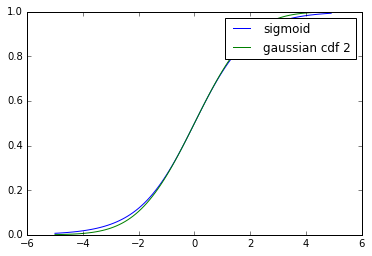

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


X = np.arange(-5, 5, 0.1)

plt.plot(X, 1 / (1 + np.exp(-X)), label='sigmoid')
# # plt.show()
# # plt.plot(X, scipy.stats.norm.cdf(X), label='gaussian cdf')
plt.plot(X, scipy.stats.norm.cdf(np.sqrt(np.pi / 8) * X), label='gaussian cdf 2')
# # plt.plot(X, scipy.stats.norm.cdf(np.pi / 5 * X), label='gaussian cdf 3')

# plt.plot(X, 1/(1 + np.exp(-0.07056 * X * X * X - 1.5976 * X)), label='log cubed')
# plt.plot(X, scipy.stats.norm.cdf(X), label='gaussian cdf 1')

plt.legend()
plt.show()


We have $\sigma(x) \approx \Phi(\sqrt{\frac{\pi}{8}}x)$

And we have:

$$
\int_{-\infty}^\infty \Phi(\lambda x)\mathcal{N}(x \mid \mu, s^2) \, dx
= \Phi\left(
    \frac{\mu}{\sqrt{\lambda^{-2} + s^2}}
\right)
$$

We want:

$$
\alpha(\mu_S, \sigma^2_S)
= \Exp_{S \sim \mathcal{N}(\mu_S, \sigma_S^2)}[f(S)]
$$

$$
= \Exp_{S \sim \mathcal{N}(\mu_S, \sigma_S^2)}
[
    y - \sigma(S)
]
$$

$$
= \int_{-\infty}^\infty (y - \sigma(S))\mathcal{N}(S \mid \mu_S, \sigma_S^2)\, dS
$$

$$
= y - \int_{-\infty}^\infty \sigma(S)\, \mathcal{N}(S \mid \mu_S, \sigma_S^2)\,dS
$$

$$
\int_{-\infty}^\infty \sigma(S) \mathcal{N}(S \mid \mu_S, \sigma_S^2)\,dS \\
\approx
\int_{-\infty}^\infty
\Phi\left(
  \sqrt{\frac{\pi}{8}}S
\right)
\,
\mathcal{N}(S \mid \mu_S, \sigma_S^2)\,dS
$$

$$
= \Phi\left(
   \frac{\mu_S}
      {\sqrt{\frac{8}{\pi} + \sigma_S^2}}
\right)
$$

$$
\approx \sigma \left(
   \sqrt{\frac{8}{\pi}}
   \frac{\mu_S}
     {\sqrt{\frac{8}{\pi} + \sigma_S^2}}
\right)
$$

$$
= \sigma \left(
   \frac{\mu_S}
      {\sqrt{1 + \frac{\pi}{8} \sigma_S^2}}
\right)
$$

So:

$$
\alpha(\mu_S, \sigma_S^2) \approx y - \sigma \left(
  \frac{\mu_S}
    {\sqrt{1 + \frac{\pi}{8}\sigma_S^2}}
\right)
$$

"This is an approximation that is used for Bayesian prediction when the posterior is approximated by a Gaussian (MacKay, 1992). As we now have a closed-form approximation of $\alpha$, one can also obtain expressions for $\beta$ and $\gamma$ by differentiating.

"Furthermore, by substituting $x = \mu + st$, differentiating with respect to $\mu$, and (8), we can even approximate the objective function (6) in a closed form:

From https://mathoverflow.net/questions/127086/integral-of-the-product-of-normal-density-and-cdf/127094#127094

"Recall that $\Phi(x) = P[X \le x]$ for every $x$, where the random variable $X$ is standard normal, and that, for every suitable function $u$,

$$
\int_{-\infty}^\infty u(x)\,\phi(x)\,dx = \Exp[u(Y)]
$$

... where the random variable $Y$ is standard normal.

Using this for $u = \Phi$, we have:

$$
\int_{-\infty}^\infty \Phi(x)\,\phi(x)\,dx = \Exp[\Phi(Y)]
$$

# interlude: try to derive the formula for $\int \Phi(\cdot)\phi(\cdot)$

See ../maths/integrate_cdf_pdf